# Chapter 13 Robust machine learning with ML Pipelines
This chapter covers

- Using transformers and estimators to transform data into ML features
- Assembling features into a vector through an ML pipeline
- Training a simple ML model
- Evaluating a model using relevant performance metrics
- Optimizing a model using cross-validation
- Interpreting a model’s decision-making process through feature weights

[Spark MLlib Guide](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

# Running Machine learning using sklearn

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from pyspark.ml.feature import VectorAssembler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with a scaler and logistic regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Hyperparameters to tune and their possible values
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['lbfgs', 'saga']
}

# Use GridSearchCV to find the best hyperparameters
clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1)

# Fit model
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Best Hyperparameters:", clf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Create a spark session

In [71]:
import sys
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# change the account name to your email account
account='sli'

# define a root path to access the data in the DataAnalysisWithPythonAndPySpark
data_path='/net/clusterhn/home/'+account+'/isa460/data/'

# append path to helper_functions to system path
sys.path.append('/net/clusterhn/home/sli/isa460')

import os
os.environ["PYSPARK_PYTHON"] = "/opt/conda/envs/BigDataEnv/bin/python3.12"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/conda/envs/BigDataEnv/bin/python3.12"

import helper_functions as H

# check if the Spark session is active. If it is activate, close it

try:
    if spark:
        spark.stop()
except:
    pass    

spark = (SparkSession.builder.appName("Preparing Featurers for Machine Learning")
        .config("spark.port.maxRetries", "200")
        .config("spark.sql.mapKeyDedupPolicy", "LAST_WIN")  # This configuration allow the duplicate keys in the map data type.
        .config("spark.driver.memory", "8g")
        .getOrCreate())

# confiture the log level (defaulty is WARN)
spark.sparkContext.setLogLevel('ERROR')

# Building a (complete) machine learning pipeline

## load processed data from Chapter 12

In [75]:
food=spark.read.parquet(data_path+'recipes/recipes_cleaned')

# find all columns that only have only 1 or 1 value
def columns_with_only_0_and_1(df):
    return [c for c in df.columns if sorted(df.agg(F.collect_set(c)).first()[0]) == [0, 1]]

BINARY_COLUMNS=columns_with_only_0_and_1(food)

# remove target desset from BINARY_COLUMNS

BINARY_COLUMNS.remove('dessert')

In [22]:
#BINARY_COLUMNS

## food_pipeline pipeline, containing three stages

In [74]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF
 
imputer = MF.Imputer(                        
    strategy="mean",
    inputCols=["rating", "calories", "protein", "fat", "sodium"],
    outputCols=["rating_i", "calories_i", "protein_i", "fat_i", "sodium_i"],
)
 
continuous_assembler = MF.VectorAssembler(  
    inputCols=["rating_i", "calories_i", "protein_i", "fat_i", "sodium_i"],
    outputCol="continuous",
)
 
continuous_scaler = MF.MinMaxScaler(         
     inputCol="continuous",
   outputCol="continuous_scaled",
)
 
food_pipeline = Pipeline(                    
     stages=[imputer, continuous_assembler, continuous_scaler]
)

## Assembling the final data set with the vector column type

In [77]:
preml_assembler = MF.VectorAssembler(
    inputCols=BINARY_COLUMNS                         
    + ["continuous_scaled"]
    + ["protein_ratio", "fat_ratio"],
    outputCol="features",
)
 
food_pipeline.setStages(
    [imputer, continuous_assembler, continuous_scaler, preml_assembler]
)
 
food_pipeline_model = food_pipeline.fit(food)        
food_features = food_pipeline_model.transform(food)

In [78]:
food_features.select("dessert", "features").show(5, truncate=100)

# Note: Since we have 513 elements in our vector, with a majority of zeroes, 
# PySpark uses a sparse vector representation to save some space.

+-------+----------------------------------------------------------------------------------------------------+
|dessert|                                                                                            features|
+-------+----------------------------------------------------------------------------------------------------+
|    0.0|(513,[14,117,238,305,348,350,367,507,508,509,510,511,512],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.10678391...|
|    0.0|(513,[12,18,29,45,76,89,139,164,167,175,178,323,331,387,400,414,421,428,457,499,504,506,507,510],...|
|    0.0|(513,[44,89,139,304,331,380,387,421,428,483,505,507,508,510,511],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0...|
|    0.0|(513,[12,18,45,53,155,159,175,322,331,355,379,428,457,474,492,498,500,506,507,508,509,510,511,512...|
|    0.0|(513,[9,12,18,45,85,91,175,216,272,325,357,414,447,457,498,500,506,507,508,509,510,511,512],[1.0,...|
+-------+----------------------------------------------------------------------------------------------------+
o

In [80]:
# chcck the labels for each feature
#food_features.schema["features"].metadata

## Training an ML model using a LogisticRegression classifier

In [81]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(
    featuresCol="features", labelCol="dessert", predictionCol="prediction"
)
 
food_pipeline.setStages(
    [
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr,
     ]
)

Pipeline_63a8560ea5a3

In [82]:
# split data into train and test set
train, test = food.randomSplit([0.7, 0.3], 13)

# cache train set in memory
train.cache()

# train the pipeline model using fit

food_pipeline_model = food_pipeline.fit(train)

# evaluate the model using transform
results = food_pipeline_model.transform(test) 

In [83]:
# check prediction result

results.select("dessert", "prediction", "rawPrediction", "probability").show(10, False)

+-------+----------+----------------------------------------+------------------------------------------+
|dessert|prediction|rawPrediction                           |probability                               |
+-------+----------+----------------------------------------+------------------------------------------+
|1.0    |1.0       |[-14.634903816133559,14.634903816133559]|[4.4069876968456314E-7,0.9999995593012303]|
|0.0    |0.0       |[7.1164268462699685,-7.1164268462699685]|[0.999188996492393,8.110035076069888E-4]  |
|0.0    |1.0       |[-3.5214247784926167,3.5214247784926167]|[0.028708739933156476,0.9712912600668435] |
|0.0    |0.0       |[17.579540950473312,-17.579540950473312]|[0.999999976809914,2.3190085962632168E-8] |
|1.0    |1.0       |[-11.383740546452309,11.383740546452309]|[1.1378875755614393E-5,0.9999886211242444]|
|0.0    |0.0       |[15.32782820032909,-15.32782820032909]  |[0.9999997796014681,2.203985318693924E-7] |
|0.0    |0.0       |[17.923203985741562,-17.92320398574

## Evaluating and optimizing our model

## Assessing model accuracy: Confusion matrix and evaluator object

In [84]:
results.groupby("dessert").pivot("prediction").count().show()

+-------+----+----+
|dessert| 0.0| 1.0|
+-------+----+----+
|    0.0|4908| 103|
|    1.0|  79|1014|
+-------+----+----+



In [85]:
# accouracy, precision, recall, f1 score

results2=results.groupby("dessert").pivot("prediction").count().collect()
results2

[Row(dessert=0.0, 0.0=4908, 1.0=103), Row(dessert=1.0, 0.0=79, 1.0=1014)]

In [86]:
TN=results2[0][1]
FP=results2[0][2]
FN=results2[1][1]
TP=results2[1][2]

accuracy=(TP+TN)/(TP+FP+TN+FN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
f1=2*(precision*recall)/(precision+recall)

print(accuracy, precision, recall, f1)

0.9701834862385321 0.9077887197851388 0.9277218664226898 0.9176470588235294


In [87]:
# use classification_report from python

from sklearn.metrics import accuracy_score, classification_report

df=results.select('dessert', 'prediction').toPandas()
label=df['dessert']
pred=df['prediction']

print("Accuracy:", accuracy_score(label, pred))
print("\n", classification_report(label, pred))

Accuracy: 0.9701834862385321

               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      5011
         1.0       0.91      0.93      0.92      1093

    accuracy                           0.97      6104
   macro avg       0.95      0.95      0.95      6104
weighted avg       0.97      0.97      0.97      6104



In [88]:
# user the model evaluate
lr_model = food_pipeline_model.stages[-1]

# input is target variable and feature
metrics = lr_model.evaluate(results.select("dessert", "features"))

# LogisticRegressionTrainingSummary
 
print(f"Model precision: {metrics.precisionByLabel[1]}") 
print(f"Model recall: {metrics.recallByLabel[1]}")  

Model precision: 0.9077887197851388
Model recall: 0.9277218664226898


### True positives vs. false positives: The ROC curve

In [89]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
evaluator = BinaryClassificationEvaluator(
    labelCol="dessert",                     
    rawPredictionCol="rawPrediction",      
    metricName="areaUnderROC",
)
 
accuracy = evaluator.evaluate(results)
print(f"Area under ROC = {accuracy} ")

Area under ROC = 0.9921193502382589 


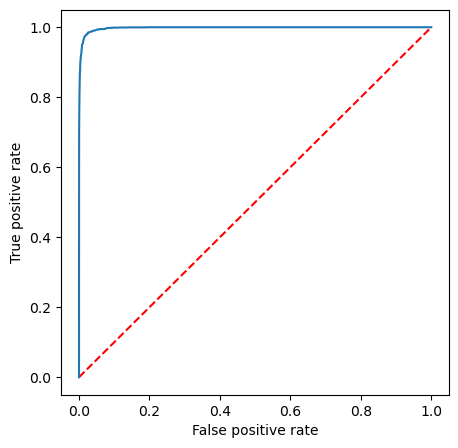

In [90]:
# plot roc curve
import matplotlib.pyplot as plt
lr_model = food_pipeline_model.stages[-1]

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
plt.plot(
    lr_model.summary.roc.select("FPR").collect(),
    lr_model.summary.roc.select("TPR").collect(),
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

## Optimizing hyperparameters with cross-validation

In [55]:
# explain the parameters of the model

#lr.explainParams()

In [91]:
# Using ParamGridBuilder to define a set of hyperparameters
from pyspark.ml.tuning import ParamGridBuilder
 
grid_search = (
    ParamGridBuilder()                          
    .addGrid(lr.elasticNetParam, [0.0, 1.0])    
    .build()                                    
)

In [92]:
# Creating and using a CrossValidator object
from pyspark.ml.tuning import CrossValidator
 
cv = CrossValidator(
    estimator=food_pipeline,
    estimatorParamMaps=grid_search,
    evaluator=evaluator,
    numFolds=5,
    seed=13,
    collectSubModels=True,
)
 
cv_model = cv.fit(train)                     
 
print(cv_model.avgMetrics)
 
pipeline_best_model = cv_model.bestModel

food_features = pipeline_best_model.transform(test)

[0.9917481270149366, 0.9917461927399485]


## Getting the biggest drivers from our model: Extracting the coefficients

In [93]:
import pandas as pd
 
feature_names = ["(Intercept)"] + [                   
    x["name"]
    for x in (
        food_features
        .schema["features"]
        .metadata["ml_attr"]["attrs"]["numeric"]
    )
]
feature_coefficients = [pipeline_best_model.stages[-1].intercept] + list(     
   pipeline_best_model.stages[-1].coefficients.values
)
 
coefficients = pd.DataFrame(
    feature_coefficients, index=feature_names, columns=["coef"]
)
 
coefficients["abs_coef"] = coefficients["coef"].abs()
 
print(coefficients.sort_values(["abs_coef"], ascending=False)[0:20])

                      coef   abs_coef
arugula         -20.297414  20.297414
poppy           -18.655244  18.655244
frangelico       18.161259  18.161259
horseradish     -17.527047  17.527047
pasta_maker     -17.213404  17.213404
meat            -17.211738  17.211738
low_sugar       -15.455209  15.455209
duck            -14.886263  14.886263
sangria         -14.879983  14.879983
bulgur          -14.526784  14.526784
leafy_green     -14.101464  14.101464
cod             -14.012722  14.012722
chicken         -13.736973  13.736973
coffee_grinder  -13.428839  13.428839
kale            -13.170996  13.170996
sandwich_theory -12.825890  12.825890
game            -12.769721  12.769721
goose           -12.628973  12.628973
mustard_greens  -11.746011  11.746011
turkey          -11.515312  11.515312


## Save the pipeline mode for future use

In [94]:
pipeline_best_model.write().overwrite().save(data_path+"recipes/dessert_best_model_logisticsRegression")

In [95]:
## Load the model

from pyspark.ml.pipeline import PipelineModel
 
loaded_model = PipelineModel.load(data_path+"recipes/dessert_best_model_logisticsRegression")

In [97]:
# input a dataset
food=spark.read.parquet(data_path+'recipes/recipes_cleaned')

# use the model to make prediction

result=loaded_model.transform(food)
result.select('dessert', 'prediction').show()

+-------+----------+
|dessert|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [100]:
result.groupBy('dessert', 'prediction').count().show()

+-------+----------+-----+
|dessert|prediction|count|
+-------+----------+-----+
|    1.0|       1.0| 3376|
|    0.0|       1.0|  216|
|    1.0|       0.0|  197|
|    0.0|       0.0|16260|
+-------+----------+-----+



# Summary

- Transformers are objects that, through a transform() method, modify a data frame based on a set of Params that drives its behavior. We use a transformer stage when we want to deterministically transform a data frame.
- Estimators are objects that, through a fit() method, take a data frame and return a fully parameterized transformer called a model. We use an estimator stage when we want to transform a data frame using a data-dependent transformer.
- ML pipelines are like estimators, as they use the fit() method to yield a pipeline model. They have a single Param, stages, that carries an ordered list of transformers and estimators to be applied on a data frame.
- Before training a model, every feature needs to be assembled in a vector using the VectorAssembler transformer. This provides a single optimized (sparse or dense) column containing all the features for machine learning.
- PySpark provides useful metrics for model evaluation through a set of evaluator objects. You select the appropriate one based on your type of prediction (binary classification = BinaryClassificationEvaluator).
- With a Param Map grid, an evaluator, and an estimator, we can perform model hyperparameter optimization to try different scenarios and try to improve model accuracy.
- Cross-validation is a technique that resamples the data frame into different partitions before fitting/testing the model. We use cross-validation to test if the model performs consistently when it sees different data.